## A model build using TweetBERT to identify cause-effect pairs in sentences of tweets

The cause-effect pair sentence prediction model will be trained on the dataset which got augmented in an active learning approach in 5 steps.

Load already preprocessed file with sentence containing either cause or effect or both. Sentences labeled as Jokes, questions or having negations are removed.

IO tagging is used instead of BIO tagging. The assumption is that the attention mechanism already encodes information about the postion (B-.). In consequence the training should be simplified with only 3 classes: I-C, I-E, O

In [2]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as classification_report_seqeval
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import transformers
from tqdm import tqdm, trange
from utils import normalizeTweet, split_into_sentences, bio_tagging, EarlyStopping
import matplotlib.pyplot as plt
from ast import literal_eval
%matplotlib inline

########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
dataPath = "data/cause_effect_sentences_with_IO_tags.csv"
#dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-5 # earlier 1e-3    
adam_eps = 1e-8
epochs = 55
num_warmup_steps = 0
early_patience = 10 # earlier 5, how long to wait after last time validation loss improved

train_batch_size = 1#8
val_batch_size = 8
test_batch_size = 8
train_to_test_ratio = 0.9 # 10% test and 90% train
val_to_train_ratio = 0.2
type_ = "cause-or-effect"
attempt_ = "test"

n_labels = 3 # 0, I-C, I-E
tag2id = {label: idx for idx, label in enumerate(["O", "I-C", "I-E"])}
tag2id[-100] = -100
id2tag = {id:tag for tag,id in tag2id.items()}

# if True, only sentences containing both cause and effect are considered.
# if False, all sentences containing either cause or effect are considered
requireCauseAndEffect = True 

# Each token has its associated IO tag ("O", "I-C", "I-E").
# The Bertweet tokenizer splits words into sub-words
# if True => assign IO tag of word to all sub-words
# if False => assign IO tag of word to first sub-word and all other sub-words get -100 (loss function ignores this index)
subwordTagEqualFirstwordTag = False 

metric_choice = "weighted" # micro, macro, samples or weighted 
# metrics_average = "binary" # this will give measure for class_1,i.e., causal class

# saveModelName = "./model-causal-span/cause-and-effect_model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved

Cuda available:  False


In [3]:
##### DATA TO LOAD ######

data = pd.read_csv(dataPath, sep=";", converters={"tokenized":literal_eval, "bio_tags":literal_eval})
print(data.shape)
data.head()

(2500, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


## Preprocessing

In [4]:
############ Choose only sentences with both cause and effect or only sentences with either cause or effect (or both) #######


if requireCauseAndEffect: # cause and effect in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) & (data["Effect"].notnull())]
else: # cause or effect or both in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) | (data["Effect"].notnull())]

print(dataSentFiltered.shape)
dataSentFiltered.head()

(2118, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


(array([137., 494., 672., 402., 179., 115.,  79.,  30.,   9.,   1.]),
 array([ 3. , 10.2, 17.4, 24.6, 31.8, 39. , 46.2, 53.4, 60.6, 67.8, 75. ]),
 <BarContainer object of 10 artists>)

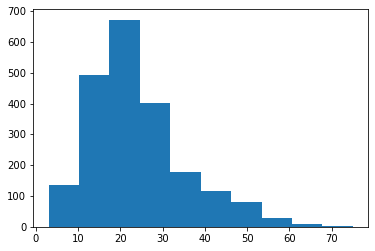

In [5]:
########## Distribution of sentences length ########################

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in dataSentFiltered["sentence"]]
plt.hist(seq_len)
#pd.Series(seq_len).hist(bins = 30)

## Training

In [6]:
trainingDataSample = dataSentFiltered #.sample(n=100)   # Only for testing
train = trainingDataSample.sample(frac=train_to_test_ratio, random_state=0)
test = trainingDataSample.drop(train.index)
validate = train.sample(frac=val_to_train_ratio, random_state=0)
train = train.drop(validate.index)
print("Train:", train.shape)
print("Validate:", validate.shape)
print("Test:", test.shape)

Train: (72, 7)
Validate: (18, 7)
Test: (10, 7)


In [7]:
######### BERTWEET TOKENIZER + PYTORCH DATASET/DATALOADER STRUCTURE ##################

class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, bio_tags, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.bio_tags = bio_tags


    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        bio_tags_extended = self.extend_tags(self.text[idx], self.bio_tags[idx], ids[idx])
        
        assert(len(ids[idx]) == len(bio_tags_extended), "token ids and IO tags lengths do not match!")
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
              , "bio_tags" : torch.tensor(list(map(lambda bioTags: tag2id[bioTags], bio_tags_extended))
, dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

    
    def extend_tags(self, tokens_old, tags_old, ids_tokenized_padded):
        """ 
            Each token has a IO tag label. 
            However BERT's tokenization splits tokens into subwords. How to label those subwords?
            
            Option 1:
            ---------
            
            add the same label to each subword than the first subword
            Ex. 
            #lowbloodsugar => '#low@@', 'blood@@', 'sugar@@'
               "I-C"       =>   "I-C" ,   "I-C"  ,   "I-C"
            
            Option 2:      
            ---------
            
            From : https://huggingface.co/transformers/custom_datasets.html#token-classification-with-w-nut-emerging-entities
            A common obstacle with using pre-trained models for token-level classification: many of the tokens in
            the W-NUT corpus are not in DistilBert’s vocabulary. Bert and many models like it use a method called 
            WordPiece Tokenization, meaning that single words are split into multiple tokens such that each token
            is likely to be in the vocabulary. For example, DistilBert’s tokenizer would split the Twitter 
            handle @huggingface into the tokens ['@', 'hugging', '##face']. This is a problem for us because we 
            have exactly one tag per token. If the tokenizer splits a token into multiple sub-tokens, then we will
            end up with a mismatch between our tokens and our labels.

            One way to handle this is to only train on the tag labels for the first subtoken of a split token. 
            We can do this in 🤗 Transformers by setting the labels we wish to ignore to -100. 
            In the example above, if the label for @HuggingFace is 3 (indexing B-corporation), we would set 
            the labels of ['@', 'hugging', '##face'] to [3, -100, -100].
        """
        tags = [-100] # add for start token <CLS>
        for token_old, tag in zip(tokens_old.split(" "), tags_old):
            #print(F"\ntoken_old: {token_old};    tag: {tag}")
            for i, sub_token in enumerate(self.tokenizer.tokenize(token_old)):
                if (i == 0): # first sub token of a word keeps the original bio tag
                    firstTag = tag
                    tags.append(tag)
                    #print(F"\tsubToken: {sub_token};    tag: {tag}")
                else: 
                    if subwordTagEqualFirstwordTag: # the other sub tokens get the first bio tag than the first sub token
                        tags.append(firstTag)
                        #print(F"\tsubToken: {sub_token};    tag: {firstTag}")
                    else: # to other sub tokens get the tag -100 (ignored in loss function)
                        tags.append(-100)
                        #print(F"\tsubToken: {sub_token};    tag: {-100}")

        tags.append(-100) # 0 for end of sentence token
    
        # append -100 for all padded elements
        padded_elements = ids_tokenized_padded.count(1) # id 1 is <PAD> ; Alternative: where attention_mask == 0 add -100
        tags.extend([-100]*padded_elements)
        
        return tags
        
        
    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", padding = "max_length", truncation = True, max_length = 60 )

train_dataset = TweetDataSet(train["sentence"].values.tolist()
                           , train["Causal association"].values.tolist()
                           , train["bio_tags"].values.tolist()
                           , tokenizer)
val_dataset = TweetDataSet(validate["sentence"].values.tolist()
                           , validate["Causal association"].values.tolist()
                           , validate["bio_tags"].values.tolist()
                           , tokenizer)
test_dataset = TweetDataSet(test["sentence"].values.tolist()
                           , test["Causal association"].values.tolist()
                           , test["bio_tags"].values.tolist()
                           , tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# put data to batches
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)


<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-7-6ea249dd8a91>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(ids[idx]) == len(bio_tags_extended), "token ids and IO tags lengths do not match!")
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


72
18
10


In [8]:
############ class weights #####################

# Since -100 will anyway be ignored by loss func, drop it
train_bio_tags = np.hstack([t["bio_tags"][t["bio_tags"]!=-100].numpy() for t in train_dataset])
print("train_bio_tags:", train_bio_tags)

train_bio_tags_count_info = (pd.Series(train_bio_tags).value_counts(normalize=True))
print("train_bio_tags_count_info:", train_bio_tags_count_info)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_bio_tags_count_info obtained above has fraction of 
# samples for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_bio_tags_count_info)/len(train_bio_tags_count_info)
class_weight = class_weight[sorted(class_weight.index)]
class_weight


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


train_bio_tags: [0 0 0 ... 0 0 0]
train_bio_tags_count_info: 0    0.834225
1    0.087166
2    0.078610
dtype: float64


0    0.399573
1    3.824131
2    4.240363
dtype: float64

## Evaluation metrics

In [9]:
def compute_metrics(pred, labels):
    """
        Dataset is unbalanced -> measure weighted metrics
        Calculate metrics for each label, and find their average wieghted by support (Number of true instances for each label)
        This alters 'macro' to account for label imbalance;
        it can result in an F-Score taht is not between precision and recall
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average= metric_choice) # TODO: check weightin
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Model definition

In [10]:
class CausalNER(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalNER, self).__init__()
        self.bert = transformers.AutoModel.from_pretrained("vinai/bertweet-base")
        #self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, n_labels)
        self.softmax = torch.nn.Softmax(-1)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
#        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_seq, _ = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_2 = self.dropout(output_seq)
        output_3 = self.linear1(output_2)
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5 # 5


In [11]:
model = CausalNER()
model.to(device)

# fine-tune only the task-specific parameters 
for param in model.bert.parameters():
    param.requires_grad = False
#     param[:-1].requires_grad = False
#     param[-1].requires_grad = True

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
# scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0;
# after a warmup period during which it increases linearly from to the initial lr set in the optimizer
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) 


## adding weight to the loss function 
loss_fn = CrossEntropyLoss(
    weight=torch.tensor(class_weight.to_list()).to(device),
    ignore_index=-100 # ignore subwords/tokens with label -100 
)

#loss_fn = CrossEntropyLoss(ignore_index=-100)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.11.output.dense.bias', 'lm_head.dense.weight', 'roberta.encoder.layer.3.attention.self.query.weight', 'roberta.encoder.layer.2.intermediate.dense.weight', 'roberta.encoder.layer.7.attention.self.query.bias', 'roberta.encoder.layer.10.attention.output.dense.weight', 'lm_head.layer_norm.weight', 'roberta.encoder.layer.10.attention.self.value.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.encoder.layer.4.output.dense.bias', 'roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.7.attention.output.dense.bia

Some weights of BertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['embeddings.LayerNorm.weight', 'encoder.layer.1.output.dense.weight', 'encoder.layer.3.output.dense.bias', 'encoder.layer.11.attention.output.dense.bias', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.8.output.LayerNorm.bias', 'encoder.layer.6.intermediate.dense.bias', 'encoder.layer.9.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.2.attention.output.dense.weight', 'encoder.layer.8.output.dense.weight', 'encoder.layer.2.attention.self.query.weight', 'encoder.layer.10.attention.self.value.bias', 'encoder.layer.7.output.LayerNorm.weight', 'encoder.layer.5.attention.output.LayerNorm.bias', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.attention.output.LayerNorm.bias', 'encoder.layer.2.attention.self.key.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.8.att

In [12]:
################ TRAINING ######################

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")

    
    ############ training eval metrics ######################
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    #########################################################
    
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        bio_tags = batch['bio_tags'].to(device)
        
        ################################################
        model.train() # set model to training mode
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass

        ################################################ 
        # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
        active_loss = attention_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
        active_logits = logits.view(-1, n_labels)[active_loss] # n_labels=53
        active_tags = bio_tags.view(-1)[active_loss]
        loss = loss_fn(active_logits, active_tags)             
        print("loss:", loss)       ## TODO VIVEK: check loss function calculation
        loss.backward() # backward pass
        ## gradient clipping to control the exploding gradient problem 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()    # update parameters and take a steup using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
            
            
        ################## Training Performance Measures ##########
        logits = logits.detach().to('cpu').numpy()
        tags_ids = bio_tags.to('cpu').numpy()

        # calculate performance measures only on tokens and not subwords or special tokens
        tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
        pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
        tags = tags_ids[tags_mask]                      
                
        metrics = compute_metrics(pred, tags)
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
                          
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))           
    print(F'\n\tTraining Loss: {np.mean(train_loss)}')
    print(F'\n\tTraining acc: {np.mean(train_acc)}')
    print(F'\n\tTraining prec: {np.mean(train_prec)}')
    print(F'\n\tTraining rec: {np.mean(train_rec)}')
    print(F'\n\tTraining f1: {np.mean(train_f1)}')

    n_trained_epochs += 1

                          
    ###################################################################################

    
    ## ---- Validation ------    
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []

    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        v_input_ids, v_input_mask, v_token_type_ids, v_labels, v_bio_tags = batch  # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            model.eval() # put model in evaluation mode for validation set
            logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions

        ######################################################
        
        # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
        v_active_loss = v_input_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
        v_active_logits = logits.view(-1, n_labels)[v_active_loss] # n_labels=3 
        v_active_tags = v_bio_tags.view(-1)[v_active_loss]
        v_loss = loss_fn(v_active_logits, v_active_tags)             
        val_loss.append(v_loss.item())
              
        #########################################################
        logits = logits.detach().to('cpu').numpy()
        tags_ids = v_bio_tags.to('cpu').numpy()

        # calculate performance measures only on tokens and not subwords or special tokens
        tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
        pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
        tags = tags_ids[tags_mask]#.flatten()        
        
        metrics = compute_metrics(pred, tags)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])
                              
    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))        
    print(F'\n\tValidation Loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./model-causal-span/{}_model_{}_finetuned-{}-epochs-lr_{}.pth".format(type_, attempt_, n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

  0%|          | 0/72 [00:00<?, ?it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 1/72 [00:00<00:12,  5.90it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 1 ======================>
loss: tensor(1.1941, grad_fn=<NllLossBackward>)



  3%|▎         | 2/72 [00:00<00:10,  6.46it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  4%|▍         | 3/72 [00:00<00:10,  6.82it/s]

loss: tensor(1.1161, grad_fn=<NllLossBackward>)
loss: tensor(1.2217, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  6%|▌         | 4/72 [00:00<00:10,  6.62it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  7%|▋         | 5/72 [00:00<00:09,  6.79it/s]

loss: tensor(1.4239, grad_fn=<NllLossBackward>)
loss: tensor(1.1744, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  8%|▊         | 6/72 [00:00<00:09,  6.85it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(1.1085, grad_fn=<NllLossBackward>)



 10%|▉         | 7/72 [00:01<00:10,  6.05it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 11%|█         | 8/72 [00:01<00:10,  5.95it/s]

loss: tensor(1.0309, grad_fn=<NllLossBackward>)
loss: tensor(1.2900, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 12%|█▎        | 9/72 [00:01<00:10,  5.96it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(1.2047, grad_fn=<NllLossBackward>)
loss: tensor(1.0913, grad_fn=<NllLossBackward>)



 14%|█▍        | 10/72 [00:01<00:10,  5.69it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 15%|█▌        | 11/72 [00:01<00:11,  5.22it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 12/72 [00:02<00:10,  5.65it/s]

loss: tensor(1.2400, grad_fn=<NllLossBackward>)
loss: tensor(1.1452, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 18%|█▊        | 13/72 [00:02<00:10,  5.69it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(0.9079, grad_fn=<NllLossBackward>)



 19%|█▉        | 14/72 [00:02<00:10,  5.35it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(1.1835, grad_fn=<NllLossBackward>)
loss: 


 21%|██        | 15/72 [00:02<00:10,  5.23it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 22%|██▏       | 16/72 [00:02<00:10,  5.38it/s]

tensor(1.1095, grad_fn=<NllLossBackward>)
loss: tensor(1.0460, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 24%|██▎       | 17/72 [00:02<00:09,  5.74it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 25%|██▌       | 18/72 [00:03<00:08,  6.08it/s]

loss: tensor(1.1047, grad_fn=<NllLossBackward>)
loss: tensor(1.5066, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 26%|██▋       | 19/72 [00:03<00:08,  6.16it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(0.9979, grad_fn=<NllLossBackward>)



 28%|██▊       | 20/72 [00:03<00:10,  4.80it/s]

loss: tensor(1.1667, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 29%|██▉       | 21/72 [00:03<00:13,  3.79it/s]

loss: tensor(0.8485, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 31%|███       | 22/72 [00:04<00:14,  3.46it/s]

loss: tensor(1.0840, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 32%|███▏      | 23/72 [00:04<00:17,  2.73it/s]

loss: tensor(1.1234, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 24/72 [00:05<00:19,  2.52it/s]

loss: tensor(1.4776, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 35%|███▍      | 25/72 [00:05<00:16,  2.78it/s]

loss: tensor(1.1657, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 36%|███▌      | 26/72 [00:05<00:15,  2.91it/s]

loss: tensor(1.1766, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 38%|███▊      | 27/72 [00:06<00:14,  3.10it/s]

loss: tensor(1.4185, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 39%|███▉      | 28/72 [00:06<00:13,  3.37it/s]

loss: tensor(1.2346, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 40%|████      | 29/72 [00:06<00:12,  3.56it/s]

loss: tensor(1.1771, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 42%|████▏     | 30/72 [00:06<00:10,  3.85it/s]

loss: tensor(1.2205, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 31/72 [00:07<00:10,  4.08it/s]

loss: tensor(0.9197, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 44%|████▍     | 32/72 [00:07<00:09,  4.06it/s]

loss: tensor(1.3444, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 46%|████▌     | 33/72 [00:07<00:09,  3.94it/s]

loss: tensor(1.0988, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 47%|████▋     | 34/72 [00:07<00:09,  3.95it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 49%|████▊     | 35/72 [00:07<00:08,  4.34it/s]

loss: tensor(1.1022, grad_fn=<NllLossBackward>)
loss: tensor(0.9318, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 36/72 [00:08<00:07,  4.82it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 51%|█████▏    | 37/72 [00:08<00:06,  5.30it/s]

loss: tensor(1.4417, grad_fn=<NllLossBackward>)
loss: tensor(1.1913, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 53%|█████▎    | 38/72 [00:08<00:06,  5.42it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 54%|█████▍    | 39/72 [00:08<00:05,  5.57it/s]

loss: tensor(1.1102, grad_fn=<NllLossBackward>)
loss: tensor(1.3710, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 56%|█████▌    | 40/72 [00:08<00:05,  5.60it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 57%|█████▋    | 41/72 [00:08<00:05,  5.78it/s]

loss: tensor(1.0687, grad_fn=<NllLossBackward>)
loss: tensor(1.0074, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 58%|█████▊    | 42/72 [00:09<00:04,  6.09it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 60%|█████▉    | 43/72 [00:09<00:04,  6.20it/s]

loss: tensor(0.9283, grad_fn=<NllLossBackward>)
loss: tensor(1.0565, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 61%|██████    | 44/72 [00:09<00:04,  5.60it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 62%|██████▎   | 45/72 [00:09<00:04,  5.60it/s]

loss: tensor(1.1142, grad_fn=<NllLossBackward>)
loss: tensor(1.0565, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 46/72 [00:09<00:04,  5.89it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 65%|██████▌   | 47/72 [00:09<00:04,  6.05it/s]

loss: tensor(0.9814, grad_fn=<NllLossBackward>)
loss: tensor(1.2471, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 48/72 [00:10<00:03,  6.22it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 49/72 [00:10<00:03,  6.22it/s]

loss: tensor(1.1417, grad_fn=<NllLossBackward>)
loss: tensor(1.2633, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 69%|██████▉   | 50/72 [00:10<00:03,  6.01it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 71%|███████   | 51/72 [00:10<00:03,  5.96it/s]

loss: tensor(1.1227, grad_fn=<NllLossBackward>)
loss: tensor(1.3908, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 72%|███████▏  | 52/72 [00:10<00:03,  5.55it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 74%|███████▎  | 53/72 [00:10<00:03,  5.74it/s]

loss: tensor(0.9541, grad_fn=<NllLossBackward>)
loss: tensor(1.2205, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 75%|███████▌  | 54/72 [00:11<00:03,  5.73it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 76%|███████▋  | 55/72 [00:11<00:02,  5.78it/s]

loss: tensor(1.0758, grad_fn=<NllLossBackward>)
loss: tensor(1.0654, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 78%|███████▊  | 56/72 [00:11<00:02,  5.76it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 79%|███████▉  | 57/72 [00:11<00:02,  5.83it/s]

loss: tensor(0.9403, grad_fn=<NllLossBackward>)
loss: tensor(1.2058, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 81%|████████  | 58/72 [00:11<00:02,  6.01it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 82%|████████▏ | 59/72 [00:11<00:02,  6.10it/s]

loss: tensor(1.2501, grad_fn=<NllLossBackward>)
loss: tensor(1.0411, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 60/72 [00:12<00:01,  6.32it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 85%|████████▍ | 61/72 [00:12<00:01,  6.30it/s]

loss: tensor(1.0965, grad_fn=<NllLossBackward>)
loss: tensor(1.3354, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 86%|████████▌ | 62/72 [00:12<00:01,  6.09it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


loss: tensor(1.1958, grad_fn=<NllLossBackward>)



 88%|████████▊ | 63/72 [00:12<00:01,  5.63it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 89%|████████▉ | 64/72 [00:12<00:01,  5.89it/s]

loss: tensor(1.1670, grad_fn=<NllLossBackward>)
loss: tensor(1.3580, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 90%|█████████ | 65/72 [00:13<00:01,  5.54it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 92%|█████████▏| 66/72 [00:13<00:01,  5.89it/s]

loss: tensor(1.1361, grad_fn=<NllLossBackward>)
loss: tensor(1.1523, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 93%|█████████▎| 67/72 [00:13<00:00,  5.66it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 94%|█████████▍| 68/72 [00:13<00:00,  5.80it/s]

loss: tensor(1.2596, grad_fn=<NllLossBackward>)
loss: tensor(0.9114, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 96%|█████████▌| 69/72 [00:13<00:00,  5.40it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 97%|█████████▋| 70/72 [00:13<00:00,  5.30it/s]

loss: tensor(1.3501, grad_fn=<NllLossBackward>)
loss: tensor(1.5052, grad_fn=<NllLossBackward>)


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 99%|█████████▊| 71/72 [00:14<00:00,  5.26it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 72/72 [00:14<00:00,  5.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss: tensor(1.4295, grad_fn=<NllLossBackward>)
loss: tensor(1.0455, grad_fn=<NllLossBackward>)

	Training Loss: 1.1635427085889711

	Training acc: 0.4694996112886941

	Training prec: 0.6925991863677567

	Training rec: 0.4694996112886941

	Training f1: 0.538056296069829


<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 1/3 [00:00<00:01,  1.44it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]<ipython-input-7-6ea249dd8a91>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

Epoch:   0%|          | 0/55 [00:15<?, ?it/s]


	Validation Loss: 1.1065971453984578

	Validation acc: 0.5769634436992496

	Validation prec: 0.6768672476701793

	Validation rec: 0.5769634436992496

	Validation f1: 0.6113702241342978
Validation loss decreased (inf --> 1.106597).  Saving model ...


FileNotFoundError: [Errno 2] No such file or directory: './model-causal-span/cause-or-effect_model_test_finetuned--9-epochs-lr_1e-05.pth'

In [29]:
print("N trained epochs:", n_trained_epochs)
print(train_avg_loss)
print(val_avg_loss)

N trained epochs: 1
[1.1464665209253628]
[1.0927389860153198]


In [ ]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

In [ ]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

## Evaluation on the test dataset

In [ ]:

############ test eval metrics ######################
test_true_labels = []
test_predict_labels = []
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []

########################################################
for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch     # unpack inputs from dataloader

    with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
        model.eval() # put model in evaluation mode for validation set
        logits = model(**{"input_ids":t_input_ids, "attention_mask":t_input_mask, "token_type_ids":t_token_type_ids}) # forward pass, calculates logit predictions

    ######################################################

    # similar to the class RobertaForToken classification in transformers: https://github.com/huggingface/transformers/blob/master/src/transformers/models/roberta/modeling_roberta.py
    t_active_loss = t_input_mask.view(-1) == 1  # either based on attention_mask (includes <CLS>, <SEP> token)
    t_active_logits = logits.view(-1, n_labels)[t_active_loss] # n_labels=3
    t_active_tags = t_bio_tags.view(-1)[t_active_loss]
    t_loss = loss_fn(t_active_logits, t_active_tags)             
    test_loss.append(t_loss.item())

    #########################################################
    logits = logits.detach().to('cpu').numpy()
    tags_ids = t_bio_tags.to('cpu').numpy()

    # calculate performance measures only on tokens and not subwords or special tokens
    tags_mask = tags_ids != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits, axis=2)[tags_mask] #.flatten() # convert logits to list of predicted labels
    tags = tags_ids[tags_mask]#.flatten()                          
    test_true_labels.append(tags) # appends true labels for batch
    test_predict_labels.append(pred) # # appends predicted labels for batch
    
    metrics = compute_metrics(pred, tags)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])


print(F'\n\tTest Loss: {np.mean(test_loss)}')
print(F'\n\tTest acc: {np.mean(test_acc)}')
print(F'\n\tTest prec: {np.mean(test_prec)}')
print(F'\n\tTest rec: {np.mean(test_rec)}')
print(F'\n\tTest f1: {np.mean(test_f1)}')


### Classification reports

In [ ]:

test_true_tag = [id2tag[ID] for ID in np.concatenate(test_true_labels)]#
test_predict_tag = [id2tag[ID] for ID in np.concatenate(test_predict_labels)]
print(classification_report(test_true_tag, test_predict_tag))

In [ ]:
#The metrics we are seeing in this report are designed specifically for NLP tasks such as NER and POS tagging,
#in which all words of an entity need to be predicted correctly to be counted as one correct prediction. 
#Therefore, the metrics in this classification report are much lower than in scikit-learn's classification report.
test_true_tag = [[id2tag[ID] for ID in IDS] for IDS in test_true_labels]
test_predict_tag = [[id2tag[ID] for ID in IDS] for IDS in test_predict_labels]
print(classification_report_seqeval(test_true_tag, test_predict_tag))

### Example: see predictions

In [ ]:
# take last batch of test set:
t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch 

for i in range(len(batch)):
    tags_mask = t_bio_tags[i].to("cpu").numpy() != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits[i], axis=1)[tags_mask]
    true_tags = t_bio_tags[i][tags_mask].to("cpu").numpy()    
    

    tokens = tokenizer.convert_ids_to_tokens(t_input_ids[i])

    print("\n\nPadded Sentence:")
    print(tokens)
    print("true labels:")
    print(t_bio_tags[i], "-> ", id2tag[t_bio_tags[i]])
    for token, true_label, pred in zip(np.array(tokens)[tags_mask], true_tags, pred):
        print(token, "\t\ttrue:", true_label, "  pred:", pred)

    
    break


